In [1]:
# Imports
import pandas as pd
import xgboost as xgb
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from combat.pycombat import pycombat

In [2]:
# Load and preprocess GBM data
def read_GBM(data_path):

    gbm = pd.read_csv(data_path/'GBM.txt', sep='\t').transpose()
    gbm.columns = [i.split('_')[1] for i in gbm.columns]
    gbm = gbm.loc[:, gbm.std() != 0]

    #take the average of duplicate columns
    gbm = gbm.groupby(gbm.columns, axis=1).mean()

    gbm = gbm.reset_index()
    gbm['index'] = gbm['index'].apply(lambda x: 'FPS_' + x)
    gbm = gbm.set_index('index')

    #add one to all values and than take log2
    gbm = gbm.apply(lambda x: np.log2(x+1))

    return gbm

gbm = read_GBM(Path('/home/fcarli/CellHit/data/transcriptomics/'))

/tmp/ipykernel_62522/1206469347.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  gbm = gbm.groupby(gbm.columns, axis=1).mean()


In [3]:
# Load XGBoost model
model = xgb.Booster()
model.load_model('/home/fcarli/francisCelligner/tumor_classifier_final_model.json')
feature_names = model.feature_names

In [4]:
# Ensure GBM data has all required features
def ensure_columns(df, columns):
    columns_set = set(columns)
    missing_columns = columns_set - set(df.columns)
    
    # Create a new DataFrame with missing columns
    new_columns = pd.DataFrame({col: pd.Series(dtype='float64') for col in missing_columns}, index=df.index)
    
    # Concatenate the new columns with the original DataFrame
    df_new = pd.concat([df, new_columns], axis=1)
    
    # Reorder columns
    all_columns = list(columns_set) #+ [col for col in df.columns if col not in columns_set]
    df_new = df_new[all_columns]
    
    return df_new

gbm = ensure_columns(gbm, list(feature_names))
gbm = gbm[feature_names]

In [5]:
# Load TCGA data
expression_data = pd.read_feather('/home/fcarli/CellHit/data/transcriptomics/celligner_CCLE_TCGA.feather')
expression_data = expression_data[expression_data['Source'] == 'TCGA'].drop(columns=['Source'])
expression_data['index'] = expression_data['index'].str[:-3]

target_data = pd.read_csv('/home/fcarli/CellHit/data/metadata/tcga_clinical.tsv', sep='\t')[['case_submitter_id', 'project_id']]
target_data['project_id'] = target_data['project_id'].apply(lambda x: x.split('-')[1])

In [6]:
# Merge expression and target data
expression_data = expression_data.merge(target_data, left_on='index', right_on='case_submitter_id', how='inner').drop_duplicates()
expression_data = expression_data.set_index('case_submitter_id')


# Create a dictionary to store indexes of samples with the same project_id
project_samples = expression_data.groupby('project_id').apply(lambda x: x.index.tolist()).to_dict()

# Print the number of samples for each project_id
for proj_id, samples in project_samples.items():
    print(f"{proj_id}: {len(samples)} samples")

#save for later SKCM for a counterfactual check
save_for_later = expression_data[expression_data['project_id']=='SKCM']
project_id = expression_data.pop('project_id')
expression_data = expression_data.transpose().iloc[1:]

/tmp/ipykernel_62522/1457318858.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  project_samples = expression_data.groupby('project_id').apply(lambda x: x.index.tolist()).to_dict()


ACC: 77 samples
ALL: 194 samples
AML: 228 samples
BLCA: 405 samples
BRCA: 1099 samples
CESC: 306 samples
CHOL: 36 samples
COAD: 290 samples
DLBC: 47 samples
ESCA: 182 samples
GBM: 166 samples
HNSC: 520 samples
KICH: 66 samples
KIRC: 531 samples
KIRP: 289 samples
LAML: 147 samples
LGG: 523 samples
LIHC: 371 samples
LUAD: 515 samples
LUSC: 498 samples
MESO: 87 samples
NBL: 162 samples
OV: 425 samples
PAAD: 179 samples
PCPG: 182 samples
PRAD: 496 samples
READ: 93 samples
SARC: 262 samples
SKCM: 469 samples
STAD: 410 samples
TGCT: 154 samples
THCA: 512 samples
THYM: 119 samples
UCEC: 181 samples
UCS: 57 samples
UVM: 79 samples
WT: 126 samples


In [7]:
# Prepare data for combat
gbm_transposed = gbm.transpose()
common_rows = expression_data.index.intersection(gbm_transposed.index)
overall_data = pd.concat([expression_data.loc[common_rows], gbm_transposed.loc[common_rows]], axis=1)

In [8]:
# Create batches and covariates
batches = [0] * expression_data.shape[1] + [1] * gbm_transposed.shape[1]
code_map = dict(zip(target_data['project_id'].astype('category').cat.codes, target_data['project_id']))
code_map_reverse = {v: k for k, v in code_map.items()}
covariates = [code_map_reverse[i] for i in project_id] + [code_map_reverse['GBM']] * gbm_transposed.shape[1]

In [10]:
# Extract GBM samples from expression_data
gbm_samples = project_samples['GBM']
gbm_expression = expression_data[gbm_samples]
gbm_expression

case_submitter_id,TCGA-19-1787,TCGA-06-5412,TCGA-41-2571,TCGA-12-5299,TCGA-06-2565,TCGA-16-0846,TCGA-06-2561,TCGA-14-0736,TCGA-06-0132,TCGA-19-2629,...,TCGA-27-2523,TCGA-27-1832,TCGA-16-1045,TCGA-06-2567,TCGA-32-2616,TCGA-28-5208,TCGA-14-2554,TCGA-27-2528,TCGA-06-5858,TCGA-14-1823
ACSL4,0.403406,0.322907,-0.124736,-0.046257,-0.529047,-0.079168,0.736514,1.155322,1.313442,0.474572,...,-0.216141,0.304156,0.454914,-0.239158,-0.36248,0.086908,0.835508,-0.639526,0.204324,1.070256
KLK13,-0.171895,-0.203967,-0.300404,-0.313673,-0.323934,-0.177809,-0.098903,-0.31637,-0.299604,-0.192079,...,-0.386255,-0.100843,-0.21014,-0.141771,-0.218163,-0.330757,-0.34521,-0.415917,-0.283151,-0.344698
RNF40,0.393094,-0.226064,0.225999,0.20201,0.034486,0.829726,0.47979,-0.898138,-0.146629,0.841342,...,0.330197,0.558539,0.287515,0.93654,0.409416,0.254165,-0.134245,0.48058,0.334363,-0.767059
LRRC25,-0.663006,-0.366416,-0.368617,-0.322306,-0.616916,-0.408766,-0.667818,-0.721726,-0.294334,0.458755,...,-0.474087,-0.326692,-0.088786,-0.482549,-0.132329,-0.31204,-0.759795,-1.389368,-0.530011,-0.667275
PITPNM2,-0.151921,-0.819108,0.3339,-0.518127,-0.522118,0.171355,0.745766,-0.771369,0.018321,0.058469,...,-0.481351,-0.448202,-0.401806,-0.961106,0.211205,-1.111624,-0.373407,-0.366405,-0.139244,-0.141065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDILT,-0.011747,-0.0081,-0.004013,-0.002828,-0.001323,-0.009212,-0.004867,-0.008695,-0.008894,0.075064,...,-0.000106,-0.008092,-0.006626,-0.013272,-0.004794,-0.002152,-0.003464,0.000412,-0.002475,-0.003469
EPHA1,-2.325821,-2.291481,-2.167465,-2.97372,-1.492816,-2.85184,-2.434027,-2.643495,-3.458744,-2.592246,...,-2.432724,-1.370338,-1.954281,-2.610936,-1.593341,-2.826209,-2.727186,-2.556916,-2.466268,-2.066171
RAB27B,-0.1534,0.453803,-0.831427,-0.300919,-0.789679,-0.27878,1.017728,0.830862,1.18162,2.243372,...,-0.752466,0.856066,0.529926,0.293832,0.773993,-0.140964,-0.25988,-1.319497,-0.769347,0.504293
HECA,0.513727,0.360279,-0.146141,-0.49445,0.502757,0.49862,0.024049,-0.566266,0.383527,0.684722,...,0.363224,0.440227,0.189154,0.564498,1.095173,0.32901,-0.145556,0.462372,0.811066,-0.414273


<Figure size 1000x800 with 0 Axes>

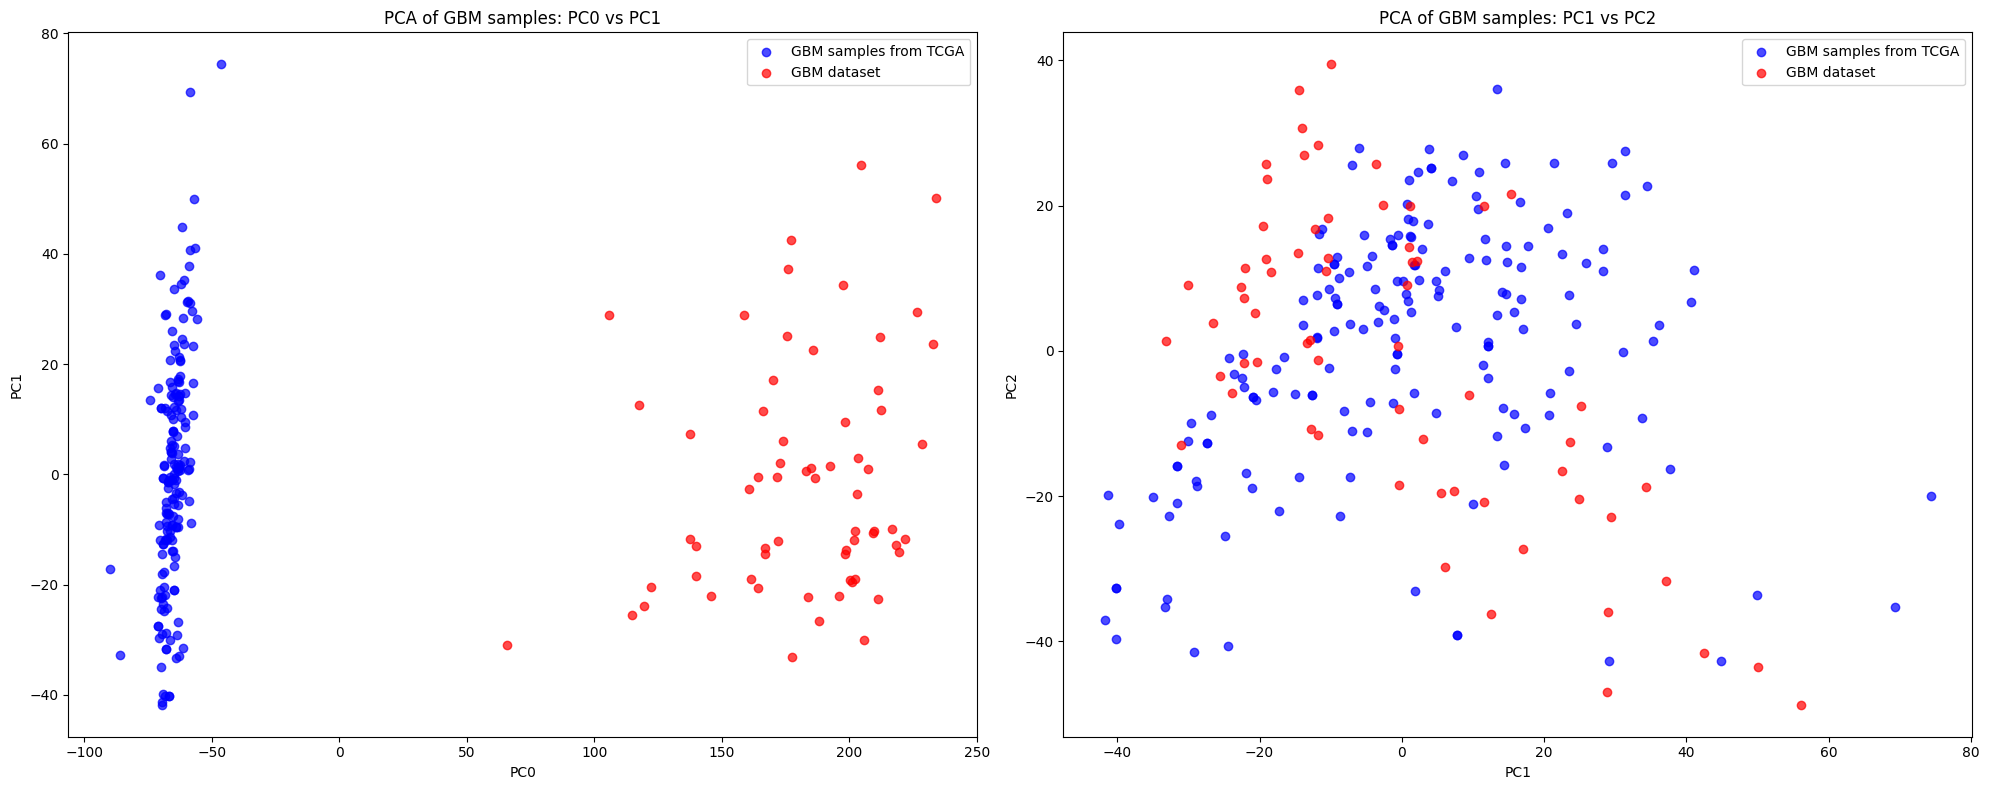

In [24]:
# Extract GBM samples from expression_data
gbm_samples = project_samples['GBM']
gbm_expression = expression_data[gbm_samples].T

data = pd.concat([gbm_expression, gbm.fillna(0)], axis=0)

# Perform PCA on both datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_pca(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=4)
    return pca.fit_transform(scaled_data)

data_pca = perform_pca(data)

# Create a single plot for both datasets
plt.figure(figsize=(10, 8))

# Calculate the number of samples in each dataset
n_gbm_expression = gbm_expression.shape[0]
n_gbm = gbm.shape[0]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 0th-1st component
ax1.scatter(data_pca[:n_gbm_expression, 0], data_pca[:n_gbm_expression, 1], 
            alpha=0.7, color='blue', label='GBM samples from TCGA')
ax1.scatter(data_pca[n_gbm_expression:, 0], data_pca[n_gbm_expression:, 1], 
            alpha=0.7, color='red', label='GBM dataset')
ax1.set_title('PCA of GBM samples: PC0 vs PC1')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax1.legend()

# Plot 1st-2nd component
ax2.scatter(data_pca[:n_gbm_expression, 1], data_pca[:n_gbm_expression, 2], 
            alpha=0.7, color='blue', label='GBM samples from TCGA')
ax2.scatter(data_pca[n_gbm_expression:, 1], data_pca[n_gbm_expression:, 2], 
            alpha=0.7, color='red', label='GBM dataset')
ax2.set_title('PCA of GBM samples: PC1 vs PC2')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.legend()

plt.tight_layout()
plt.show()

In [27]:
# Apply combat
data = pycombat(overall_data.fillna(0), batches, covariates)

/tmp/ipykernel_62522/2054845020.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = pycombat(overall_data.fillna(0), batches, covariates)


Found 2 batches.
Adjusting for 36 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/fcarli/.conda/envs/provenv/lib/python3.11/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


<Figure size 1000x800 with 0 Axes>

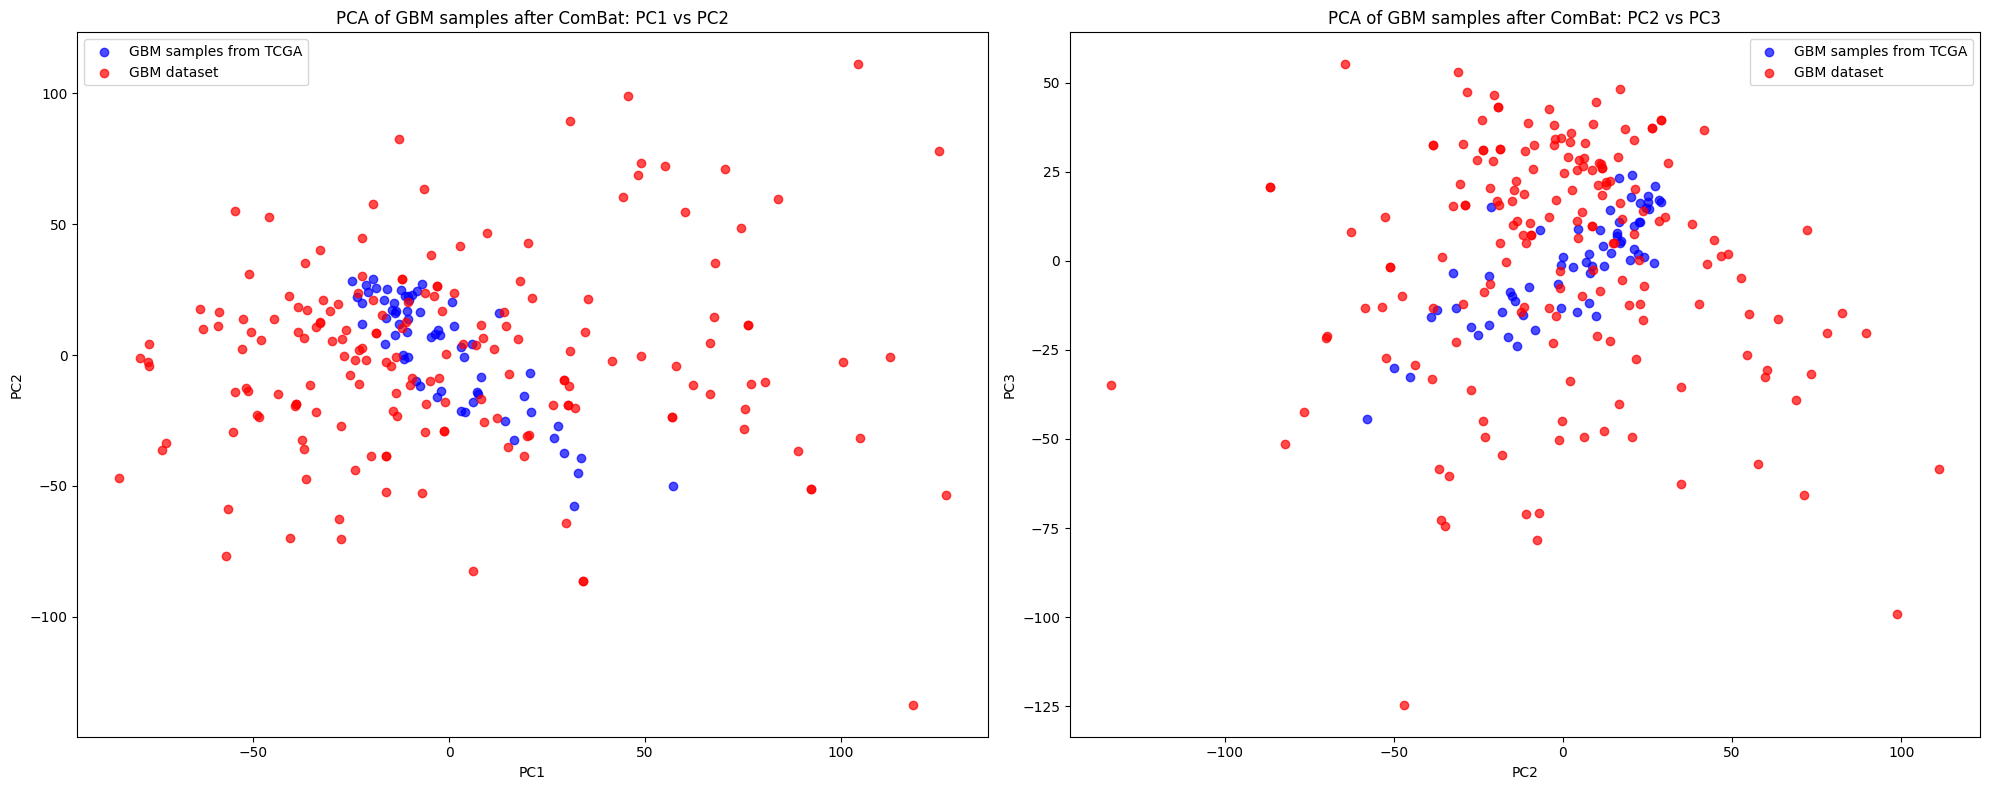

In [35]:
data_after_combat = data.T

#fps data
fps_data = data_after_combat.loc[[i for i in data_after_combat.index if 'FPS' in i]]

#gbm from TCGA
gbm_tcga = data_after_combat.loc[list(project_samples['GBM'])]


data_pca_combat = pd.concat([fps_data, gbm_tcga], axis=0)

# Perform PCA on the combat-adjusted data
data_pca_combat = perform_pca(data_pca_combat)

# Create a single plot for both datasets after combat
plt.figure(figsize=(10, 8))

# Calculate the number of samples in each dataset
n_gbm_expression = fps_data.shape[0]
n_gbm = gbm_tcga.shape[0]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot PC1 vs PC2 for both datasets after combat
ax1.scatter(data_pca_combat[:n_gbm_expression, 0], data_pca_combat[:n_gbm_expression, 1], 
            alpha=0.7, color='blue', label='GBM samples from TCGA')
ax1.scatter(data_pca_combat[n_gbm_expression:, 0], data_pca_combat[n_gbm_expression:, 1], 
            alpha=0.7, color='red', label='GBM dataset')
ax1.set_title('PCA of GBM samples after ComBat: PC1 vs PC2')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend()

# Plot PC2 vs PC3 for both datasets after combat
ax2.scatter(data_pca_combat[:n_gbm_expression, 1], data_pca_combat[:n_gbm_expression, 2], 
            alpha=0.7, color='blue', label='GBM samples from TCGA')
ax2.scatter(data_pca_combat[n_gbm_expression:, 1], data_pca_combat[n_gbm_expression:, 2], 
            alpha=0.7, color='red', label='GBM dataset')
ax2.set_title('PCA of GBM samples after ComBat: PC2 vs PC3')
ax2.set_xlabel('PC2')
ax2.set_ylabel('PC3')
ax2.legend()

plt.tight_layout()
plt.show()





In [ ]:
# Make predictions on adjusted GBM data
adjusted = data.iloc[:, [col.startswith('FPS') for col in data.columns]].transpose()
adjusted_dmatrix = xgb.DMatrix(adjusted)
predictions = model.predict(adjusted_dmatrix)
predictions = [code_map[i] for i in predictions]

print("Predictions for GBM data:", predictions)

In [ ]:
# Process SKCM data
skcm = save_for_later.drop(columns=['project_id','index']).transpose()
common_rows = expression_data.index.intersection(skcm.index)
overall_data = pd.concat([expression_data.loc[common_rows], skcm.loc[common_rows]], axis=1)
batches = [0] * expression_data.shape[1] + [1] * skcm.shape[1]
covariates = [code_map_reverse[i] for i in project_id] + [code_map_reverse['GBM']] * skcm.shape[1]

In [ ]:
# Apply combat to SKCM data
data = pycombat(overall_data.fillna(0), batches, covariates)

In [ ]:
# Apply combat to SKCM data
data = pycombat(overall_data.fillna(0), batches, covariates)

# Make predictions on adjusted SKCM data
new_data = data.transpose().iloc[-save_for_later.shape[0]:]
adjusted_dmatrix = xgb.DMatrix(new_data)
predictions = model.predict(adjusted_dmatrix)
predictions = [code_map[i] for i in predictions]

print("Predictions for SKCM data:", predictions)